#PCA AND LDA COMPARISON

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
# 1 For colab
from google.colab import drive
drive.mount('/content/drive')
# Load data into memory
data = pd.read_csv("/content/drive/MyDrive/SMMAI/data.csv") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data into memory
#data = pd.read_csv('data.csv')

print(data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [ ]:
# Convert data into a matrix
data = np.array(data)

print(data.shape)

# Dataset has 42_000 observations of 28 x 28 dimension
# flattening 28 x 28 -> 784 = 28 * 28 dimensional vector 

# Split data into a matrix X and a vector Y where:
#
# X is dimension (42000, 784)
# Y is dimension (42000, )
# Y is the first column of data, while X is the rest
X = data[:, 1:]
X = X.T

Y = data[:, 0]

print("")
print(X.shape, Y.shape)

d, N = X.shape

(42000, 785)

(784, 42000) (42000,)


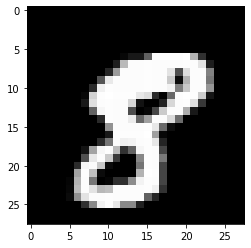

8


In [ ]:
# How to visualize image in Python?
import matplotlib.pyplot as plt

# Load an image in memory
idx = 10
img = X[:, idx]
img = np.reshape(img, (28, 28))

# Visualize
plt.imshow(img, cmap='gray')
plt.show()

print(Y[idx])

In [ ]:
# Create a function that takes as input two arrays X and Y 
# and an integer Ntrain and returns four arrays
# Xtrain, Ytrain, Xtest and Ytest where:
#
# Xtrain is composed by N_train random samples from X
# Xtest is the rest of the array X
# Ytrain and Ytest accordingly
#
# Limitation: the sample has to be random (numpy.random.shuffle)
#
# Example: If Ntrain = 30_000 on our MNIST data, the shapes
#           should be:
#           Xtrain (784, 30_000) Ytrain (30_000, )
#           Xtest  (784, 12_000) Ytest  (12_000, )
#
# Hint: 1 - Generate a vector idx = [0, ..., N-1]
#       2 - Shuffle the vector idx
#       3 - Extract from X and Y the elements corresponding 
#           to idx[:N_train]
#  If you apply the shuffle() directly on X, it will shuffle the
#  rows.
def split_data(X, Y, Ntrain):
    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

#set random state for code reproducibiliy
seed = 42
np.random.seed(seed)
random.seed(seed)
# Test it
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, 30_000)

print(Xtrain.shape, Xtest.shape)

(784, 30000) (784, 12000)


In [ ]:
from IPython.core.oinspect import find_file
def get_subset(X,Y,digits):
  #idx = [i for i,j in enumerate(Y) if j in digits]
  #X = X[:, idx]
  #Y = Y[idx]
  subset_X = []
  subset_Y = []
  for d in digits:
    idx = (Y==d)
    subset_X.append(X[:, idx])
    subset_Y.append(Y[idx])
  # Concatenate the data
  X_digits = np.concatenate(subset_X, axis=1)
  Y_digits = np.concatenate(subset_Y)
  return X_digits,Y_digits

def get_centroid(X):
  centroid = np.mean(X, axis = 1)
  return centroid

def truncated_matrix(U,s,VT,k):
  Uk = U[:,:k]
  sk = s[:k]
  VTk = VT[:k, :]
  return Uk,sk,VTk


#compute the digits clusters
def get_clusters(Z,Y,digits):
  clusters=[]
  for d in digits:
    idx = (Y==d)
    clusters.append(Z[:,idx])
  return clusters

# Visualize the clusters
def plot(Z,Y,digits,k):
  clusters = get_clusters(Z,Y,digits)
  plt.figure(figsize=(12,6))
  #scatter plot with a legend
  if(k==2):
    sc = plt.scatter(Z[0,:], Z[1,:], c=Y, cmap='tab10')
    plt.legend(*sc.legend_elements(), title='clusters')
    for i,cluster in enumerate(clusters):
      centroid = get_centroid(cluster)
      plt.plot(centroid[0],centroid[1],'*', color='r')
  if(k==3):
    ax = plt.axes(projection='3d')
    sc = ax.scatter(Z[0,:], Z[1,:], Z[2,:], c=Y, cmap='tab10')
    plt.legend(*sc.legend_elements(), title='clusters')
    for i,cluster in enumerate(clusters):
      centroid = get_centroid(cluster)
      ax.plot(centroid[0],centroid[1],centroid[2], '*', color='yellow')
  plt.show()


# compute distances between the points of a cluster and its centroid
def compute_distances(clusters, Y, digits):
  distances = []
  #clusters = get_clusters(Z,Y,digits)
  for d,cluster in enumerate(clusters):
    centroid = get_centroid(cluster)
    sum = 0
    for i in range(0, cluster.shape[1]):
      sum = sum + np.linalg.norm(cluster[:,i] - centroid)
    average_distance = sum / cluster.shape[1]
    print(f"Average_distance for cluster of digit {digits[d]}(shape: {cluster.shape}) from its centroid is {average_distance}")
    distances.append(average_distance)

#classify the cluster of a point x 
def classification_accuracy(X,Y,clusters,P,digits):
  #clusters = get_clusters(Z,Y,digits)
  centroids = []
  correct = 0
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  for i in range(0,X.shape[1]):
    distances = []
    x = X[:,i]
    #project the point x into the projection space
    projected_x = P@x 
    #print(x.shape, centroids[0].shape)
    for centroid in centroids:
      distances.append(np.linalg.norm(projected_x-centroid))
   #if(check):
     #print(distances)
      #print(f"argmin: {np.argmin(distances)}")
      #print(f"predicted: {digits[np.argmin(distances)]}")
      #check=False
    #take the minimum distance
    predicted = digits[np.argmin(distances)]
    if(predicted == Y[i]):
      correct+=1
  #print(f"the point x is more closer to the cluster of digit {predicted}")
  accuracy = (correct/X.shape[1])*100
  #print("Accuracy is: ", accuracy, "%")
  return accuracy


In [ ]:
import scipy
import scipy.sparse
import scipy.sparse.linalg

#m2 = u2 @ np.diag(s2) @ vh2  # rank-2 approx
def PCA(X,Y,k):
  #compute centroid 
  centroid = get_centroid(X)
  #reshape
  centroid = np.reshape(centroid,(centroid.shape[0], 1))
  Xc = X - centroid
  U, s, VT = np.linalg.svd(Xc, full_matrices=False)
  #Uk is the truncated projection matrix
  #Uk, sk, VTk = truncated_matrix(U,s,VT,k)
  Uk = U[:,:k]
  #projected space
  Zk = Uk.T@Xc
  return Zk, Uk.T

#LDA
def LDA(X,Y,digits,k):
  clusters = get_clusters(X,Y,digits)
  centroids = []
  centered_clusters = []
  Xbar = []
  global_centroid = get_centroid(X)
  for cluster in clusters:
    centroid = get_centroid(cluster)
    #centroids.append(get_centroid(cluster))
    new_cluster = cluster - centroid.reshape((centroid.shape[0],1)) 
    centered_clusters.append(new_cluster)
    # Compute the Xbar
    Xbar.append(np.repeat(centroid.reshape(centroid.shape[0], 1), cluster.shape[1], axis=1))
  # Compute the within-cluster matrix by concatenation
  Xw = np.concatenate(centered_clusters, axis=1)
  # Compute the within-cluster scatter matrix (the correlation matrix for points inside of each cluster.)
  Sw = Xw @ Xw.T
  #Compute the Xbar
  Xbar = np.concatenate(Xbar, axis=1)
  # Compute the between-cluster centered dataset
  Xbarc = Xbar - global_centroid.reshape((global_centroid.shape[0], 1))
  # Compute the between-cluster scatter matrix
  Sb = Xbarc @ Xbarc.T
  # We want to compute the Cholesky decomposition of Sw
  try:
    L = np.linalg.cholesky(Sw)
  except:
    epsilon = 1e-6
    Sw = Sw + epsilon * np.eye(Sw.shape[0])
    L = np.linalg.cholesky(Sw)
  # Compute the first k eigenvector decomposition of L^-1 Sb L
  _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L, k=k)
  W = np.real(W)
  # Compute Q(projection matrix)
  Q = np.linalg.inv(L).T @ W
  # Compute the projection space
  Z = Q.T @ X
  return Z, Q.T

In [ ]:
def execute_train(Xtrain, Ytrain, digits, k, algorithm, verbose = False):
  X, Y = get_subset(Xtrain, Ytrain, digits)
  if(verbose):
    print(f"Training with {algorithm}")
    print(f"shape of X:{X.shape}, shape of Y: {Y.shape}")
  #Z:projected space, Uk <--> projection matrix, 
  if (algorithm == 'PCA'):
    Z, projection_matrix = PCA(X,Y,k)
  elif (algorithm == 'LDA'):
    Z, projection_matrix = LDA(X,Y, digits,k)
  else: raise Exception("The algorithm variable should be 'PCA' or 'LDA'")
  if(verbose):
    print(f"shape of projected_space:{Z.shape}")
    print(f"shape of projection_matrix:{projection_matrix.shape}")
  #clusters from the projection space
  clusters = get_clusters(Z,Y,digits)
  if(k==2 and verbose):
    plot(Z,Y,digits,k)
  if(verbose):
    compute_distances(clusters,Y,digits)
  train_accuracy = classification_accuracy(X,Y, clusters, projection_matrix, digits)
  if(verbose):
    print(f"Accuracy on training set is: {train_accuracy}%")
    print("------------------------------------------------------------------------")

  return train_accuracy, projection_matrix, clusters

#Test set
def execute_test(Xtest, Ytest, projection_matrix, train_clusters, algorithm, digits, k, verbose = False):
  X_test,Y_test = get_subset(Xtest, Ytest, digits)

  if(verbose):
    print(f"Test with {algorithm}")
    print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape} ")
  #project the test data in the projection space
  Z_test = projection_matrix @ X_test
  if(verbose):
    print(f"Z_test shape: {Z_test.shape}")
  test_clusters = get_clusters(Z_test, Y_test, digits)
  #plot
  #if(k==2 and verbose):
    #plot(Z_test, Y_test, digits,k)
  if(verbose):
    compute_distances(test_clusters, Y_test, digits)
  #to classify the test set, do we should use the training clusters and not the test clusters? --> ASK  
  #predicting the test data wrt test clusters is not too smart
  test_accuracy = classification_accuracy(X_test,Y_test, train_clusters, projection_matrix, digits)
  #test_accuracy = classification_accuracy(X_test,Y_test, test_clusters, projection_matrix, digits)
  if(verbose):
    print(f"Accuracy on test set with {algorithm} is: {test_accuracy}%")
    print("------------------------------------------------------------------------")
  return test_accuracy


shape of X:(784, 8869), shape of Y: (8869,)
shape of projected_space:(2, 8869)
shape of projection_matrix:(2, 784)


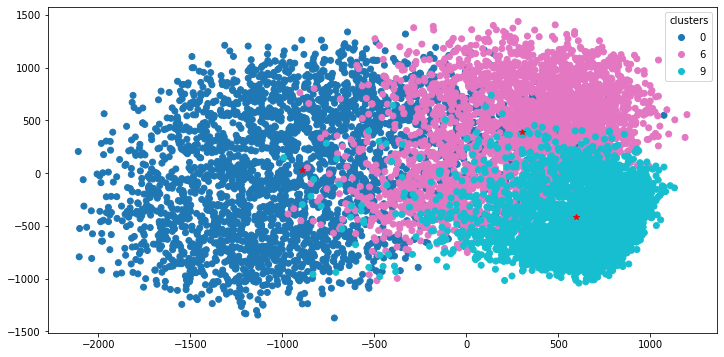

Average_distance for cluster of digit 0(shape: (2, 2963)) from its centroid is 733.4691196546362
Average_distance for cluster of digit 6(shape: (2, 2957)) from its centroid is 546.6014679580547
Average_distance for cluster of digit 9(shape: (2, 2949)) from its centroid is 359.1928926386378
Accuracy on training set is: 62.3181869432856%
------------------------------------------------------------------------
shape of X:(784, 8869), shape of Y: (8869,)
shape of projected_space:(2, 8869)
shape of projection_matrix:(2, 784)


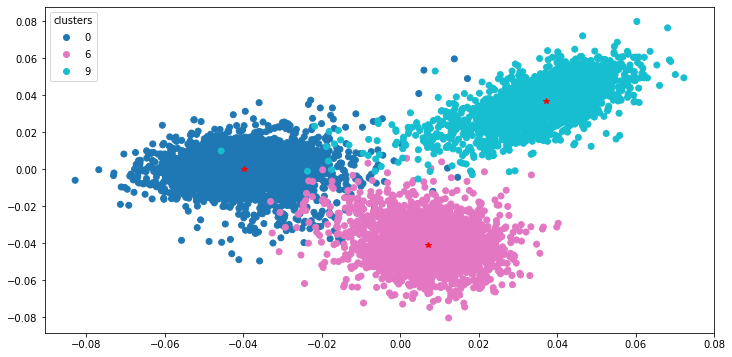

Average_distance for cluster of digit 0(shape: (2, 2963)) from its centroid is 0.013001776660478642
Average_distance for cluster of digit 6(shape: (2, 2957)) from its centroid is 0.012124205490295442
Average_distance for cluster of digit 9(shape: (2, 2949)) from its centroid is 0.01247631511785633
Accuracy on training set is: 98.8048257977224%
------------------------------------------------------------------------
X_test shape: (784, 3588), Y_test shape: (3588,) 
Z_test shape: (2, 3588)
Average_distance for cluster of digit 0(shape: (2, 1169)) from its centroid is 744.9442256518713
Average_distance for cluster of digit 6(shape: (2, 1180)) from its centroid is 510.5000523709911
Average_distance for cluster of digit 9(shape: (2, 1239)) from its centroid is 365.4174462057278
Accuracy on test set with PCA is: 62.82051282051282%
------------------------------------------------------------------------
X_test shape: (784, 3588), Y_test shape: (3588,) 
Z_test shape: (2, 3588)
Average_distance

In [ ]:
k=2
digits = [0,6,9]
#digits = [0,1,3,5,6,7,8,9]
#the prefix p stands for PCA, and l stands for LDA
p_train_acc, p_projection_matrix, p_train_clusters = execute_train(Xtrain,Ytrain,digits,k,'PCA',True)
l_train_acc, l_projection_matrix, l_train_clusters = execute_train(Xtrain,Ytrain,digits,k,'LDA',True)
p_test_accuracy = execute_test(Xtest, Ytest, p_projection_matrix,p_train_clusters,'PCA', digits, k, True)
l_test_accuracy = execute_test(Xtest, Ytest, l_projection_matrix,l_train_clusters,'LDA', digits, k, True)
#train_acc, projection_matrix, train_clusters = PCA_train(Xtrain,Ytrain,digits,k, True)
#test_acc = PCA_test(Xtest,Ytest, projection_matrix, train_clusters,digits,k,True)


The main difference between PCA and LDA is that in the latter we center the dataset by shifting each column by the centroid of each class, instead of using a global centroid for the data.
Given the quantities defined above, the idea of LDA is to build a projector Q such that the within-clusters distance of the projected data is as small as possible, while the between-clusters distance of the projected data is as big as possible.
The average distance between each cluster and its centorid is different in PCA and LDA. In PCA the distances are much more bigger than LDA average distances. In fact, this also can be seen in the plots. The clusters are more sparse in PCA, the within and between clusters distances are not minimized and maximized respectively, as in LDA. In LDA the clusters are much more densed and more distinguishable.   

In [ ]:
#Maybe the classification of the test set in incorrect, because you need to classify the test set into the projected space (training clusters) already defined by training data.
digits = [[0,6,9],[0,1,3,6,9],[0,1,3,5,6,7,8,9]]
k = [3,10,50,100,200]
#key is k, the values are the training and test accuracy for the different set of digits
summary = {}
final = []
first = True
for k in k:
  p_test_acc = []
  l_test_acc = []
  #if(k<4):
   #verbose = True
  for d in digits:
    if(k==3 and first):
      print(f"K={k}, digits: {d}")
      verbose = True
      first= False
    else: verbose=False
    p_train_acc, p_projection_matrix, p_train_clusters = execute_train(Xtrain,Ytrain,d,k,'PCA',verbose)
    l_train_acc, l_projection_matrix, l_train_clusters = execute_train(Xtrain,Ytrain,d,k,'LDA',verbose)
    p_test_accuracy = execute_test(Xtest, Ytest, p_projection_matrix,p_train_clusters,'PCA',d,k,verbose)
    l_test_accuracy = execute_test(Xtest, Ytest, l_projection_matrix,l_train_clusters,'LDA',d,k,verbose)
    p_test_acc.append(p_test_accuracy)
    l_test_acc.append(l_test_accuracy)
    #verbose = False
  result = {}
  result['PCA'] = p_test_acc
  result['LDA'] = l_test_acc
  summary[k] = result
 # print(summary)
 # print(f"K = {k}, accuracy for different digits set:")
  #print(f"digits: {digits}")
 # print(f"training accuracy: {train_acc}")
  #print(f"test accuracy: {test_acc}")

print('Summary:')
print(f"digits: {digits}")
for key,values in summary.items():
  print(f"K = {key}")
  print(f"PCA test accuracy: {values['PCA']}")
  print(f"LDA test accuracy: {values['LDA']}")
  

shape of X:(784, 8869), shape of Y: (8869,)
shape of projected_space:(3, 8869)
shape of projection_matrix:(3, 784)
Average_distance for cluster of digit 0(shape: (3, 2963)) from its centroid is 852.5629632509459
Average_distance for cluster of digit 6(shape: (3, 2957)) from its centroid is 715.0484518696308
Average_distance for cluster of digit 9(shape: (3, 2949)) from its centroid is 477.8170390449671
Accuracy on training set is: 80.94486413349871%
------------------------------------------------------------------------
shape of X:(784, 8869), shape of Y: (8869,)
shape of projected_space:(3, 8869)
shape of projection_matrix:(3, 784)
Average_distance for cluster of digit 0(shape: (3, 2963)) from its centroid is 0.013002049976902708
Average_distance for cluster of digit 6(shape: (3, 2957)) from its centroid is 0.012124476585230224
Average_distance for cluster of digit 9(shape: (3, 2949)) from its centroid is 0.01247659395409334
Accuracy on training set is: 98.8048257977224%
------------

It is possible to deduce from the results obtained by executing PCA and LDA with different k values on different set of digits, that LDA performs much better wrt to PCA, in particular when it comes to classify a bigger number of digits. 
The first thing that we can see from the results is that both the algorithms struggle more to classify a bigger set of digits, and also that by increasing k until a threshold(K=50), the accuracy on test set is improved. 

PCA tends to perform worse for small k values and for bigger set of digits, but if k is increased until a certain point, then there is an improvement in the accuracy rate for all the different set of digits, even though the trend of having less accuracy for more complex sets remains valid. 

Instead as we already known from theory, LDA tends to perform much better than PCA for clustering tasks, also for small k values. By increasing the k values,the accuracy improves only for big set of digits, and also in this case until a threshold value, after which there in no a substantial improvement.  

(2, 1000)
(2, 1100)
(1100,)


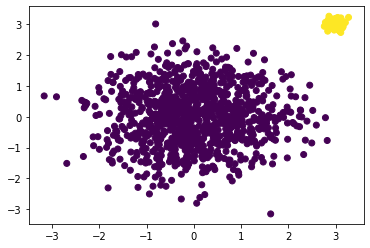

In [ ]:
#EXAMPLE OF SCATTER PLOT
import numpy as np
import matplotlib.pyplot as plt

# Create two cloud of points in 2-dimensional space
# and plot it, divided by color
x1 = np.random.normal(0, 1, (2, 1000))
x2 = np.random.normal(3, 0.1, (2, 100))
print(x1.shape)


y1 = np.zeros((1000, ))
y2 = np.ones((100, ))

# Visualize them (coloring by class)

# Join together x1 x2, y1 y2
X1 = np.concatenate((x1, x2), axis=1)
print(X.shape)
Y1 = np.concatenate((y1, y2))
print(Y.shape)
# Visualize
plt.scatter(X1[0, :], X1[1, :], c=Y1)
plt.show()

#VISUALIZING DYADS


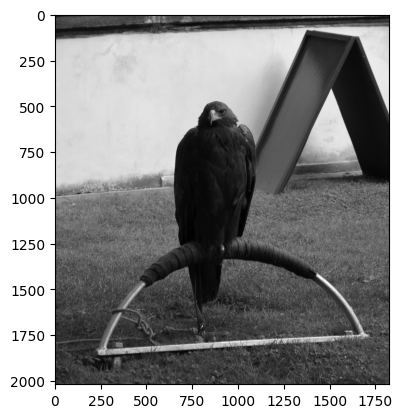

image shape: (2019, 1826)


In [3]:
# Load the image from skimage.data
from skimage import data

# image of a eagle
image = data.eagle()

# Visualize the image
plt.imshow(image, cmap='gray')
plt.show()

print(f'image shape: {image.shape}')


In [4]:
#Compute SVD
U, s, VT = np.linalg.svd(image, full_matrices=False)
print(U.shape,s.shape,VT.shape)

(2019, 1826) (1826,) (1826, 1826)


k: 1


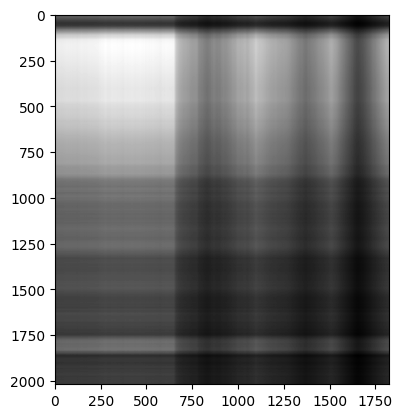

k: 3


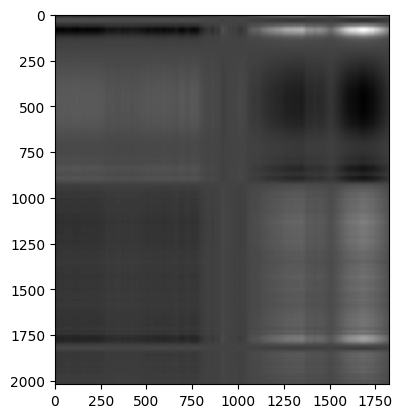

k: 5


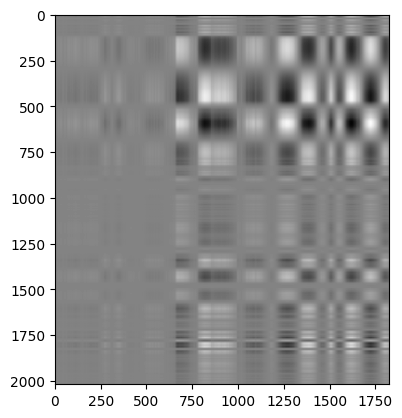

k: 100


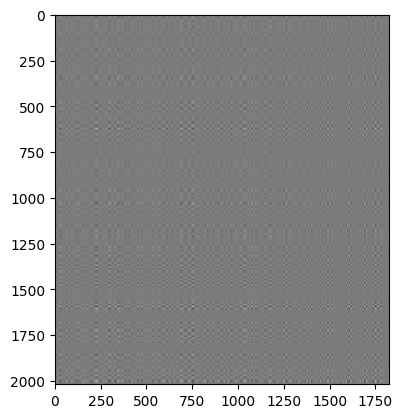

In [5]:
# visualize some of the dyad
K = [1,3,5,100]
for k in K:
  X = s[k-1]* np.dot(U[:,k-1].reshape(U.shape[0],1),VT[k-1,:].reshape(1,VT.shape[1]))
  print(f"k: {k}")
  plt.imshow(X, cmap='gray')
  plt.show()

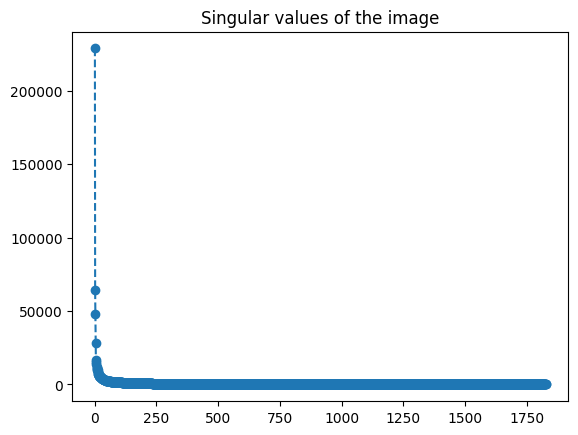

In [6]:
#plotting the singular values of the image
xs = np.linspace(1,len(s),num=len(s))
#xs = range(1,len(s)+1)
plt.title("Singular values of the image")
plt.plot(xs, s, '--o')
plt.show()

The plot shows the behaviour of the singular values obtained by SVD decomposition of the image.
It is possibile to notice that the most valuable information about the image is enclosed into the initial singular values, and after a certain point they tend to zero. 

In [7]:
def k_rank(U,s,VT,current_k, prev_k, sum):
  for k in range(prev_k,current_k):
    X = s[k]* np.dot(U[:,k].reshape(U.shape[0],1),VT[k,:].reshape(1,VT.shape[1]))
    sum = sum + X
  return sum

k: 1


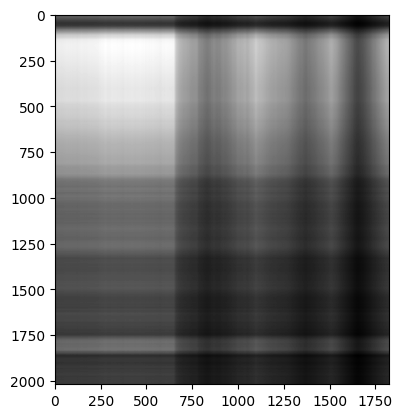

k: 20


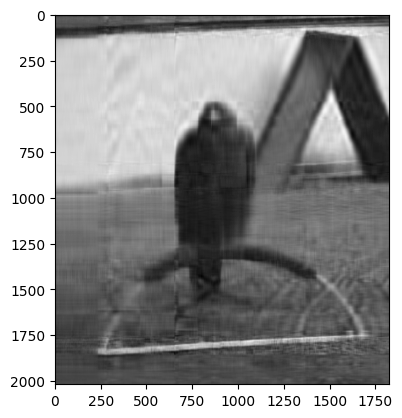

k: 50


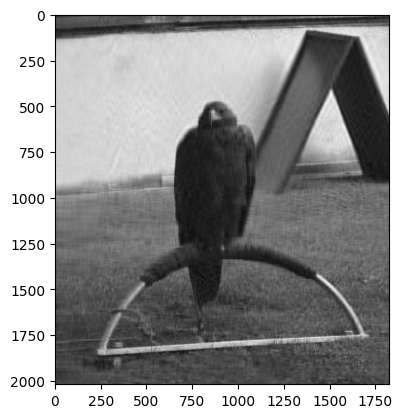

k: 100


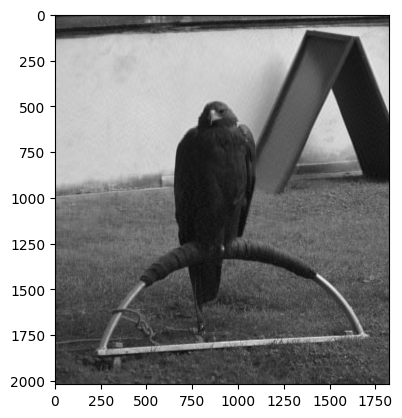

k: 200


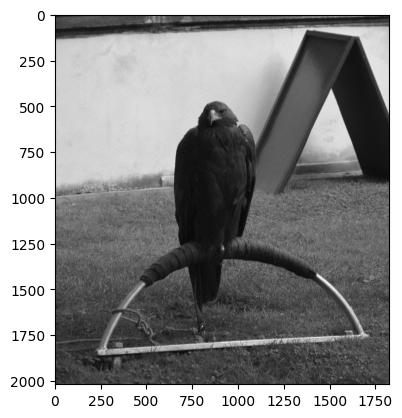

k: 500


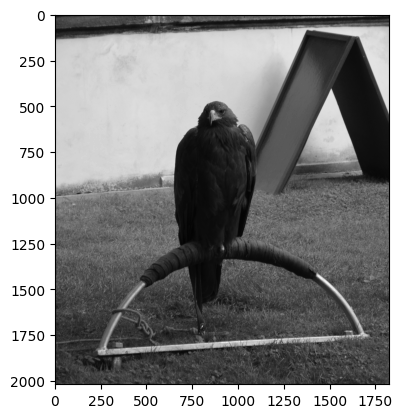

In [8]:
# Visualize the k-rank approximation of the image for different values of k 
K = [1,20,50,100,200,500]
sum = 0
for i,k in enumerate(K):
  prev = K[i-1] if i>0 else 0 
  X = k_rank(U,s,VT,k,prev,sum)
  sum = X
  #X = s[k]* np.dot(U[:,k].reshape(U.shape[0],1),VT[k,:].reshape(1,VT.shape[1]))
  print(f"k: {k}")
  plt.imshow(X, cmap='gray')
  plt.show()

k: 1


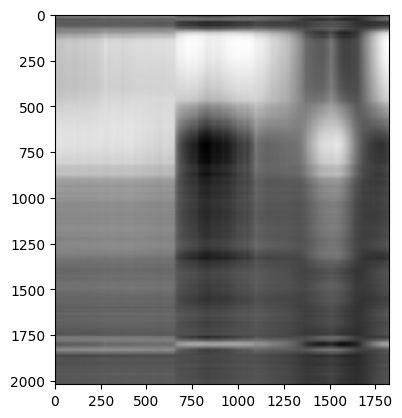

k: 5


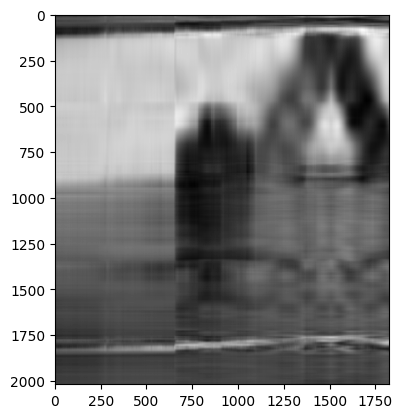

k: 10


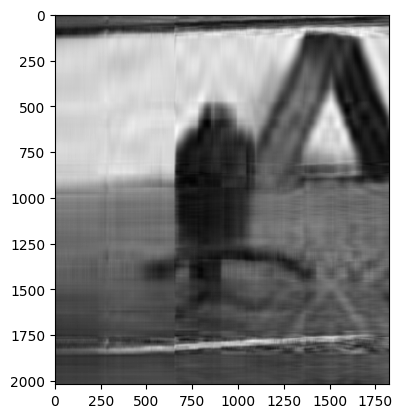

k: 25


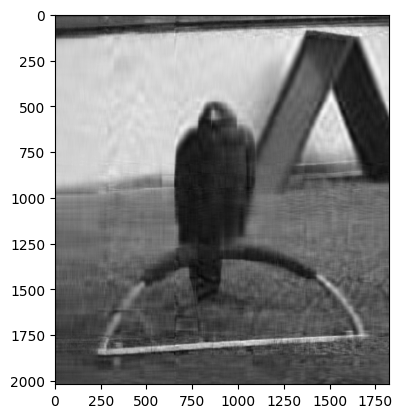

k: 50


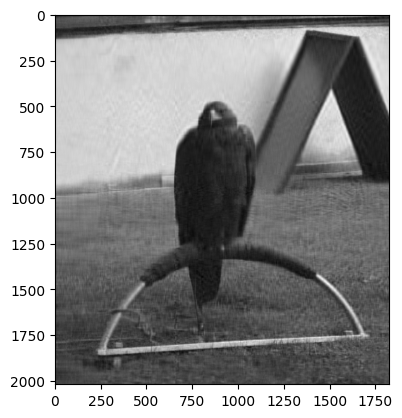

k: 100


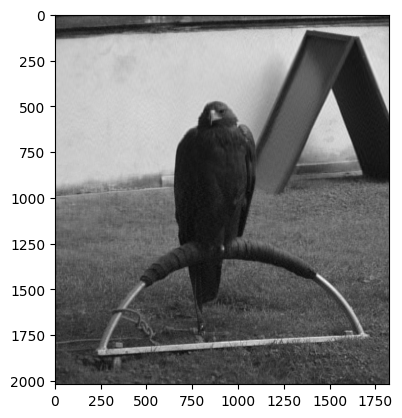

k: 200


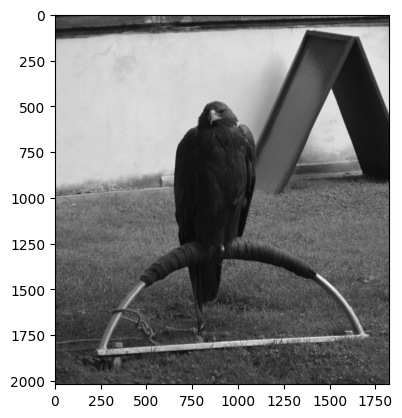

k: 500


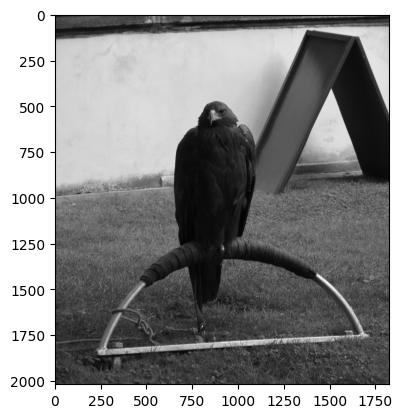

In [16]:
# Visualize the k-rank approximation of the image for different values of k 
#compression factor --> (m*n)/k(1+m+n)
K = [1,5,10,25,50,100,200,500]
sum = 0
error = []
compression_factor = []
for k in range(len(s)):
  #prev = K[i-1] if i>0 else 0 
  #X = k_rank(U,s,VT,k,prev,sum)
  Xk = s[k]* np.dot(U[:,k].reshape(U.shape[0],1),VT[k,:].reshape(1,VT.shape[1]))
  sum = sum + Xk
  if(k in K):
    cf = (Xk.shape[0]*Xk.shape[1])/(k*(1+Xk.shape[0]+Xk.shape[1]))
    error.append(np.linalg.norm(image-sum))
    compression_factor.append(cf)
    print(f"k: {k}")
    plt.imshow(sum, cmap='gray')
    plt.show()

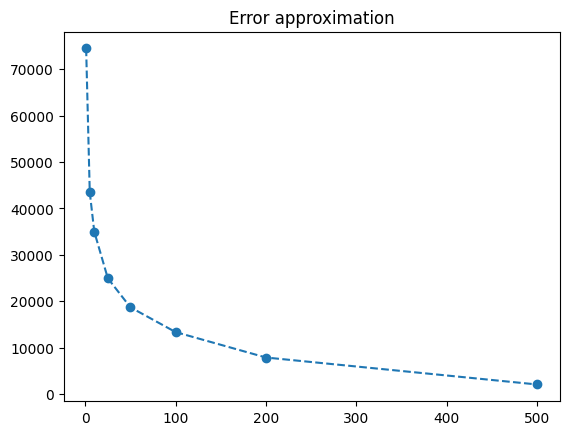

In [17]:
#plot the approxiamation error for increasing values of k
#kx = np.linspace(1,len(K),num=len(s))
#xs = range(1,len(s)+1)
plt.title("Error approximation")
plt.plot(K, error, '--o')
plt.show()

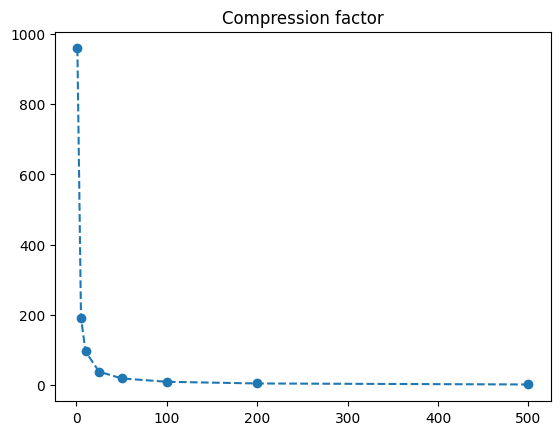

In [18]:
# cf formula (m*n)/(k*(1+m+n)) 
plt.title("Compression factor")
plt.plot(K, compression_factor, '--o')
plt.show()

From the above plot regarding the compression factor of the original image m*n, in a k approximated image, we can notice that bigger is the value of k, smaller is the compression factor wrt the original image. 

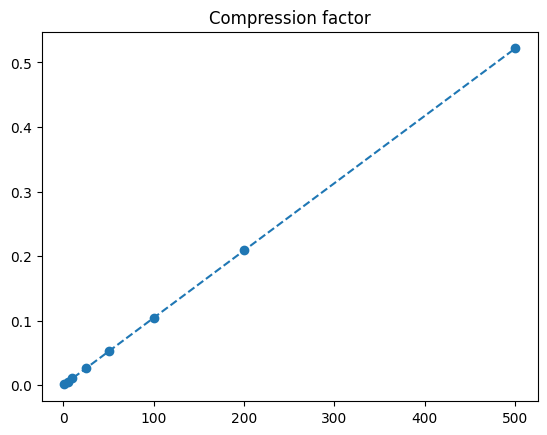

In [ ]:
# cf formula (k*(1+m+n))/(m*n)) compression by a factor of 1000 with respect to k
plt.title("Compression factor")
plt.plot(K, compression_factor, '--o')
plt.show()